<center>
<h1>Simple Py-ART Usage </h1>
<i>Scott Collis<sup>1</sup> and 
Jonathan Helmus<sup>1</sup> 
<br>
1:Argonne National Laboratory
<br>
</center>


In this tutorial we are going to load some data from the Miami NEXRAD radar. Have a little look at the (non-standard) data by plotting it on a map. Do a simple modification to a field and take a closer look at the data!

In [1]:
#first we do some imports and check the version of Py-ART for consistency
import pyart
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
print(pyart.__version__)


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119

1.9.2


read the data into our data model

In [2]:
#you can grab the data here: http://engineering.arm.gov/~collis/KAMX_20140417_1056
filename = 'data/KAMX_20140417_1056'
radar = pyart.io.read(filename)

Lets see what data we get with this radar

In [3]:
print(radar.fields.keys())

dict_keys(['reflectivity', 'differential_phase', 'differential_reflectivity', 'spectrum_width', 'velocity', 'cross_correlation_ratio'])


To save some memory we are going to only store the first two sweeps from this radar volume.

In [4]:
radar = radar.extract_sweeps([0, 1])

In [5]:
import matplotlib
matplotlib.__version__

'3.0.2'

Ok! We are going to use Py-ART's RadarMapDisplay class to visualize this PPI on a map of the coast line. This class is well documented and available here: <a href = 'http://arm-doe.github.io/pyart/dev/user_reference/generated/pyart.graph.RadarMapDisplay.html#pyart.graph.RadarMapDisplay'>Click!</a>

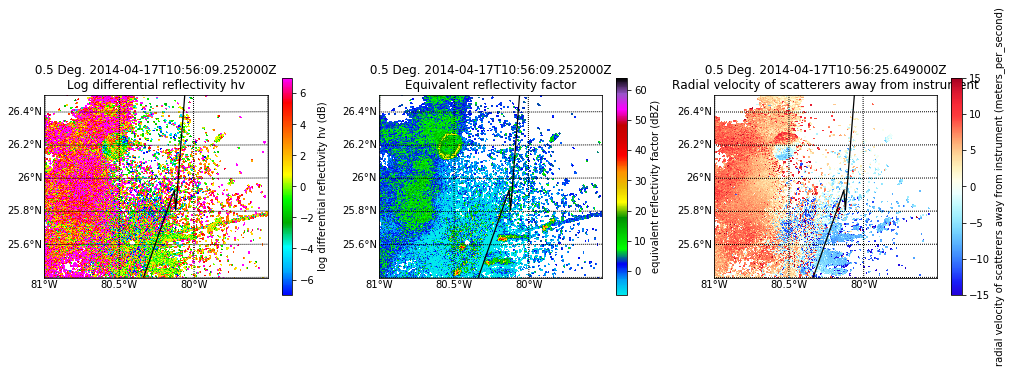

In [6]:
#create an instance of the class using our radar
display = pyart.graph.RadarMapDisplay(radar)
#create a Matplotlib figure
f = plt.figure(figsize = [17,4])
#now we are going to do a three panel plot, resolution is a basemap parameter and determines the resolution of 
#the coastline.. here we set to intermediate or 'i' ('h' for high 'l' for low)
plt.subplot(1, 3, 1) 
display.plot_ppi_map('differential_reflectivity', max_lat = 26.5, min_lat =25.4, min_lon = -81., max_lon = -79.5,
                     vmin = -7, vmax = 7, lat_lines = np.arange(20,28,.2), lon_lines = np.arange(-82, -79, .5),
                     resolution = 'l')
plt.subplot(1, 3, 2) 
display.plot_ppi_map('reflectivity', max_lat = 26.5, min_lat =25.4, min_lon = -81., max_lon = -79.5,
                     vmin = -8, vmax = 64, lat_lines = np.arange(20,28,.2), lon_lines = np.arange(-82, -79, .5),
                     resolution = 'l')
plt.subplot(1, 3, 3) 
display.plot_ppi_map('velocity', sweep = 1, max_lat = 26.5, min_lat =25.4, min_lon = -81., max_lon = -79.5,
                     vmin = -15, vmax = 15, lat_lines = np.arange(20,28,.2), lon_lines = np.arange(-82, -79, .5),
                     resolution = 'l')

 

Super cool! Hey, take a look at the interesting feature at 26.2$^\circ$N, 80.5$^\circ$W.. Clear radial velocity signature, intresting torus shape in $Z_e$ and a hint of something in differential reflectivity.. Lets do an 8-point smooth on the $Z_{dr}$ and see if things become more apparent.

In [7]:
# First we create an independant copy of one of our radar fields.. we need to make sure changes made do not 
# infer back onto the object it was copied from (common cause of issues in Python)

smooth_zdr = radar.fields['differential_reflectivity']['data'].copy()

# Now for each of the radials in the volume we want to do an 8-point smooth by convolving the data with a Hanning window..
# rather than write out the code here we are going to use Py-ART's smooth and trim function which also makes sure
# the returned array has the same size as the original array.. 
# Check here: https://github.com/ARM-DOE/pyart/blob/master/pyart/correct/phase_proc.py#L242

for i in range(smooth_zdr.shape[0]):
    smooth_zdr[i,:] = pyart.correct.phase_proc.smooth_and_trim(smooth_zdr[i,:], 8)

# Now that we have add this data as a new field, using the same metadata as the 
# differential_reflectivity field.

radar.add_field_like('differential_reflectivity', 'differential_reflectivity_smooth',  smooth_zdr)

ok! We have made a new field.. now for the cool part: Since the field conforms to our data model <b> visualization routines simply work!</b>

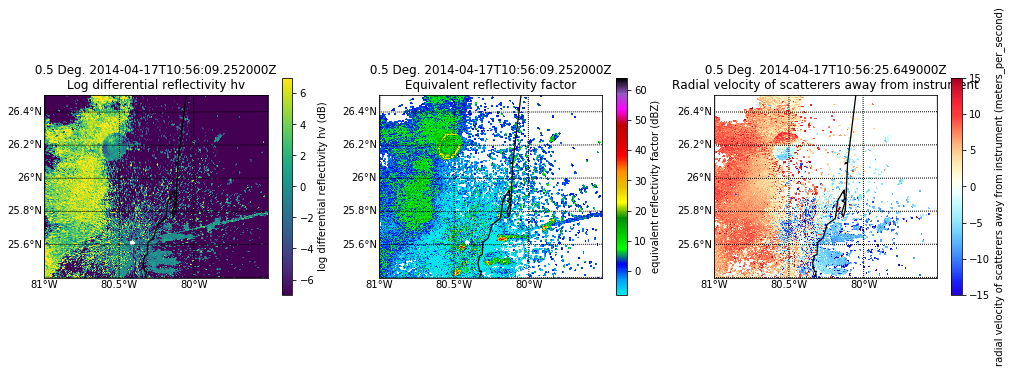

In [8]:
f = plt.figure(figsize = [17,4])
plt.subplot(1, 3, 1) 
display.plot_ppi_map('differential_reflectivity_smooth', max_lat = 26.5, min_lat =25.4, min_lon = -81., max_lon = -79.5,
                     vmin = -7, vmax = 7, lat_lines = np.arange(20,28,.2), lon_lines = np.arange(-82, -79, .5),
                     resolution = 'i')
plt.subplot(1, 3, 2) 
display.plot_ppi_map('reflectivity', max_lat = 26.5, min_lat =25.4, min_lon = -81., max_lon = -79.5,
                     vmin = -8, vmax = 64, lat_lines = np.arange(20,28,.2), lon_lines = np.arange(-82, -79, .5),
                     resolution = 'i')
plt.subplot(1, 3, 3) 
display.plot_ppi_map('velocity', sweep = 1, max_lat = 26.5, min_lat =25.4, min_lon = -81., max_lon = -79.5,
                     vmin = -15, vmax = 15, lat_lines = np.arange(20,28,.2), lon_lines = np.arange(-82, -79, .5),
                     resolution = 'i')

 

Hmm.. We are starting to see something in our $Z_{dr}$ here now.. lets zoom in for a closer look by changing the min/max_lat/lon

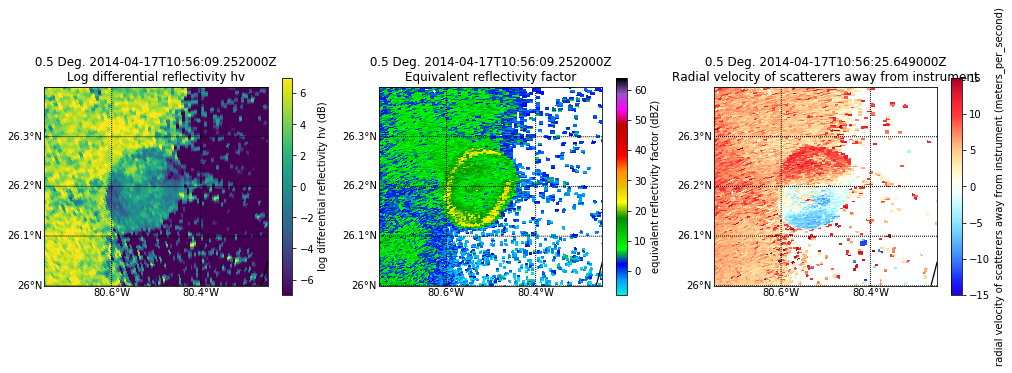

In [9]:
display = pyart.graph.RadarMapDisplay(radar)
f = plt.figure(figsize = [17,4])
plt.subplot(1, 3, 1) 
display.plot_ppi_map('differential_reflectivity_smooth', max_lat = 26.4, min_lat =26, min_lon = -80.75, max_lon = -80.25,
                     vmin = -7, vmax = 7, lat_lines = np.arange(20,28,.1), lon_lines = np.arange(-82, -79, .2),
                     resolution = 'c')
plt.subplot(1, 3, 2) 
display.plot_ppi_map('reflectivity', max_lat = 26.4, min_lat =26, min_lon = -80.75, max_lon = -80.25,
                     vmin = -8, vmax = 64, lat_lines = np.arange(20,28,.1), lon_lines = np.arange(-82, -79, .2),
                     resolution = 'c')
plt.subplot(1, 3, 3) 
display.plot_ppi_map('velocity', sweep = 1, max_lat = 26.4, min_lat =26, min_lon = -80.75, max_lon = -80.25,
                     vmin = -15, vmax = 15, lat_lines = np.arange(20,28,.1), lon_lines = np.arange(-82, -79, .2),
                     resolution = 'c')

 

Take a read of the BAMS article by Zirnic and Ryzhkov: http://journals.ametsoc.org/doi/pdf/10.1175/1520-0477%281999%29080%3C0389%3APFWSR%3E2.0.CO%3B2

Should also be a $\delta_{dp}$ signal on top of $\phi_{dp}$.. Lets take a look 

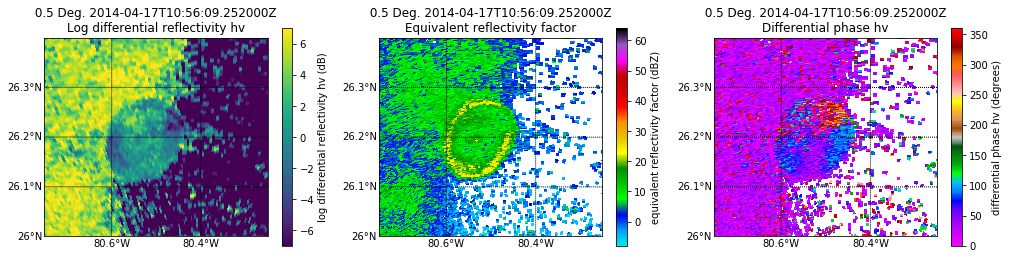

In [10]:
f = plt.figure(figsize = [17,4])
plt.subplot(1, 3, 1) 
display.plot_ppi_map('differential_reflectivity_smooth', max_lat = 26.4, min_lat =26, min_lon = -80.75, max_lon = -80.25,
                     vmin = -7, vmax = 7, lat_lines = np.arange(20,28,.1), lon_lines = np.arange(-82, -79, .2),
                     resolution = 'l')
plt.subplot(1, 3, 2) 
display.plot_ppi_map('reflectivity', max_lat = 26.4, min_lat =26, min_lon = -80.75, max_lon = -80.25,
                     vmin = -8, vmax = 64, lat_lines = np.arange(20,28,.1), lon_lines = np.arange(-82, -79, .2),
                     resolution = 'l')
plt.subplot(1, 3, 3) 
display.plot_ppi_map('differential_phase', sweep = 0, max_lat = 26.4, min_lat =26, min_lon = -80.75, max_lon = -80.25,
                     vmin = 0, vmax = 360, lat_lines = np.arange(20,28,.1), lon_lines = np.arange(-82, -79, .2),
                     resolution = 'l')

 

finally, now that we have gone to the trouble to do some value adding lets save the data out... 

In [11]:
pyart.io.write_cfradial('data/roostring.nc', radar)

And we can use ncdump to ensure it is a CF-Radial netCDF file

In [12]:
!ncdump -h data/roostring.nc

netcdf roostring {
dimensions:
	time = UNLIMITED ; // (1440 currently)
	range = 1832 ;
	sweep = 2 ;
	string_length = 32 ;
variables:
	double time(time) ;
		time:long_name = "time_in_seconds_since_volume_start" ;
		time:units = "seconds since 2014-04-17T10:56:09Z" ;
		time:standard_name = "time" ;
		time:calendar = "gregorian" ;
		time:comment = "Coordinate variable for time. Time at the center of each ray, in fractional seconds since the global variable time_coverage_start" ;
	float range(range) ;
		range:long_name = "range_to_measurement_volume" ;
		range:units = "meters" ;
		range:standard_name = "projection_range_coordinate" ;
		range:axis = "radial_range_coordinate" ;
		range:spacing_is_constant = "true" ;
		range:comment = "Coordinate variable for range. Range to center of each bin." ;
		range:meters_to_center_of_first_gate = 2125. ;
		range:meters_between_gates = 250. ;
	double azimuth(time) ;
		azimuth:long_name = "azimuth_angle_from_true_north" ;
		azimuth:units = "degrees" ;
	